<a href="https://colab.research.google.com/github/zamoraricardo15/Intro-to-Health-Informatics/blob/main/Covid_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approximation for misinformation estimation: COVID-19

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.7 MB/s 
     |████████████████████████████████| 588.3 MB 14 kB/s 
     |████████████████████████████████| 439 kB 33.6 MB/s 
     |████████████████████████████████| 6.0 MB 38.2 MB/s 
     |████████████████████████████████| 1.7 MB 55.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.1

In [6]:
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from string import punctuation
import tensorflow as tf
import tensorflow.keras.layers as tfl
import zipfile
from tensorflow.keras import Sequential, Input
from tensorflow.keras.utils import get_file
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text, sequence
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
BATCH_SIZE = 64
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 9


In [7]:
fake_df = pd.DataFrame(dict(title=[], isFakeNews=[], src=[]))

Fake and real news dataset:
https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In [8]:
fakecsv_df = pd.read_csv('/content/Fake.csv')
truecsv_df = pd.read_csv('/content/True.csv')

fakecsv_df['isFakeNews'] = True
truecsv_df['isFakeNews'] = False
fakecsv_df['src'] = 'Fake-and-real-news-dataset'
truecsv_df['src'] = 'Fake-and-real-news-dataset'
fake_df = fake_df\
                    .append(fakecsv_df[['title', 'isFakeNews', 'src']])\
                    .append(truecsv_df[['title', 'isFakeNews', 'src']])

FakeNewsNet:
https://github.com/KaiDMML/FakeNewsNet

In [9]:
politic_df = pd.read_csv("/content/politifact_real.csv")
politifake_df = pd.read_csv("/content/politifact_fake.csv")
politic_df['isFakeNews'] = False
politifake_df['isFakeNews'] = True
politifact_df = politic_df.append(politifake_df)
politifact_df['src'] = 'FakeNewsNet/politifact'
fake_df = fake_df.append(politifact_df[['title', 'isFakeNews', 'src']])

In [10]:
realgossip_df = pd.read_csv("/content/gossipcop_real.csv")
fakegossip_df = pd.read_csv("/content/gossipcop_fake.csv")
realgossip_df['isFakeNews'] = False
fakegossip_df['isFakeNews'] = True
gossipcop_df = realgossip_df.append(fakegossip_df)
gossipcop_df['src'] = 'FakeNewsNet/gossipcop'
fake_df = fake_df.append(gossipcop_df[['title', 'isFakeNews', 'src']])

COVID-19 Rumor Dataset:
https://github.com/MickeysClubhouse/COVID-19-rumor-dataset

In [11]:
newss_df = pd.read_csv('/content/en_dup.csv')
newss_df = newss_df[~(newss_df['label'] == 'U')] 
newss_df['label'] = newss_df['label']  == 'F' 
newss_df['src'] = 'COVID-19-rumor-dataset' 
newss_df = newss_df[['label', 'content', 'src']].rename(columns={'label':'isFakeNews','content':'title'}) 
fake_df = fake_df.append(newss_df)

FakeCovid:
https://github.com/Gautamshahi/FakeCovid

In [12]:
jun_df = pd.read_csv("/content/FakeCovid_June2020.csv")
jul_df = pd.read_csv("/content/FakeCovid_July2020.csv")
jun_df.loc[jun_df['class'] == 'TRUE', 'isFakeNews'] = False
jul_df.loc[jul_df['class'] == 'TRUE', 'isFakeNews'] = False
jun_df['isFakeNews'].fillna(True, inplace = True)
jul_df['isFakeNews'].fillna(True, inplace = True)
jun_df['src'] = 'FakeCovid'
jul_df['src'] = 'FakeCovid'
fake_df = fake_df\
                    .append(jun_df[['ref_title', 'isFakeNews','src']].rename(columns={'ref_title':'title'}))\
                    .append(jul_df[['source_title', 'isFakeNews','src']].rename(columns={'source_title':'title'}))

In [13]:
fake_df.dropna(inplace=True)
fake_df.to_csv("data_fake_df.csv", index=False)

In [14]:
fake_df.head()

,title,isFakeNews,src
0,Donald Trump Sends Out Embarrassing New Year’...,1.0,Fake-and-real-news-dataset
1,Drunk Bragging Trump Staffer Started Russian ...,1.0,Fake-and-real-news-dataset
2,Sheriff David Clarke Becomes An Internet Joke...,1.0,Fake-and-real-news-dataset
3,Trump Is So Obsessed He Even Has Obama’s Name...,1.0,Fake-and-real-news-dataset
4,Pope Francis Just Called Out Donald Trump Dur...,1.0,Fake-and-real-news-dataset


In [15]:
df_data = "/content/data_fake_df.csv"
df = pd.read_csv(df_data)
df.head()

,title,isFakeNews,src
0,Donald Trump Sends Out Embarrassing New Year’...,1.0,Fake-and-real-news-dataset
1,Drunk Bragging Trump Staffer Started Russian ...,1.0,Fake-and-real-news-dataset
2,Sheriff David Clarke Becomes An Internet Joke...,1.0,Fake-and-real-news-dataset
3,Trump Is So Obsessed He Even Has Obama’s Name...,1.0,Fake-and-real-news-dataset
4,Pope Francis Just Called Out Donald Trump Dur...,1.0,Fake-and-real-news-dataset


In [16]:
lenmmax = df["title"].apply(lambda x : len(x.split())).max()
worcount = 100000
length_data = len(df)
length_data

86002

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86002 entries, 0 to 86001
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       86002 non-null  object 
 1   isFakeNews  86002 non-null  float64
 2   src         86002 non-null  object 
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


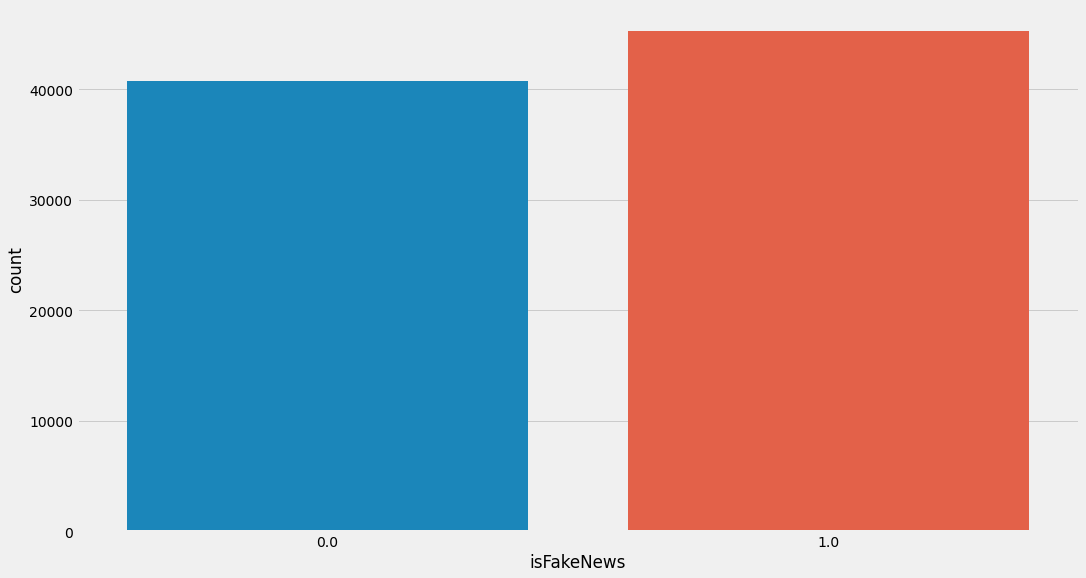

In [18]:
sns.countplot(data=df, x='isFakeNews')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,0] 
print(X.head())
y = df.iloc[:,1] 
print(y.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)


0     Donald Trump Sends Out Embarrassing New Year’...
1     Drunk Bragging Trump Staffer Started Russian ...
2     Sheriff David Clarke Becomes An Internet Joke...
3     Trump Is So Obsessed He Even Has Obama’s Name...
4     Pope Francis Just Called Out Donald Trump Dur...
Name: title, dtype: object
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: isFakeNews, dtype: float64


In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((68801,), (17201,), (68801,), (17201,))

In [21]:
max_len = np.max(X_train.apply(lambda x :len(x)))
print(max_len)

899


In [22]:
def convert_dtypes(x, y):
    return tf.cast(x, tf.uint16), tf.cast(y, tf.uint8)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)
x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')
x_train, y_train = convert_dtypes(x_train, y_train)
x_test, y_test = convert_dtypes(x_test, y_test)
print(vocab_length)


60902


In [23]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(TensorShape([68801, 899]),
 TensorShape([17201, 899]),
 TensorShape([68801]),
 TensorShape([17201]))

In [24]:
tf.keras.layers.Embedding(vocab_length, 16, input_length=max_len)
from tensorflow.keras.layers import *

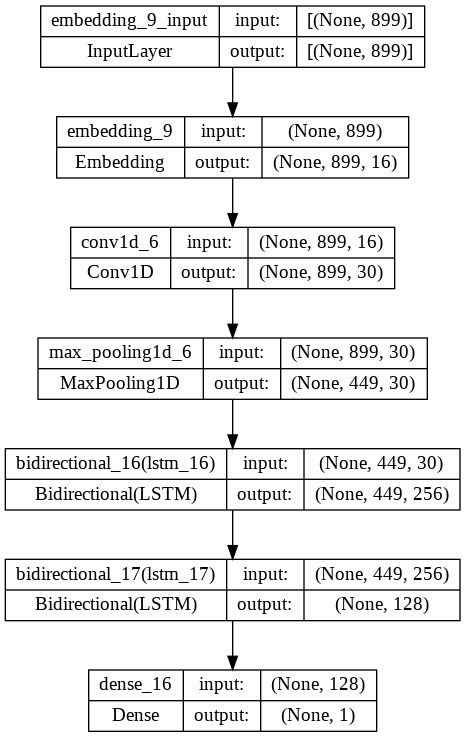

In [56]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    Conv1D(filters=30, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, strides=2),
    #Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    #MaxPooling1D(pool_size=2, strides=2),
      #Bidirectional(tfl.LSTM(128, return_sequences=True, input_shape=(worcount, lenmmax))),
      #Bidirectional(tfl.LSTM(128, return_sequences=False)),
      #Bidirectional(tfl.LSTM(128)),
      #Dropout(0.2),
      #Dense(128, activation='relu')
      #Dense(64, activation='relu')
      #Dense(1, activation='sigmoid')
    #Dropout(0.3),
    
    Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True,
               recurrent_dropout=0, dropout=0.25, recurrent_activation='sigmoid')),
    Bidirectional(LSTM(units=64, recurrent_dropout=0, dropout=0, activation='tanh',
               recurrent_activation='sigmoid', unroll=False, use_bias=True)),
#Flatten(),
    #Dropout(0.2),
    #Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)


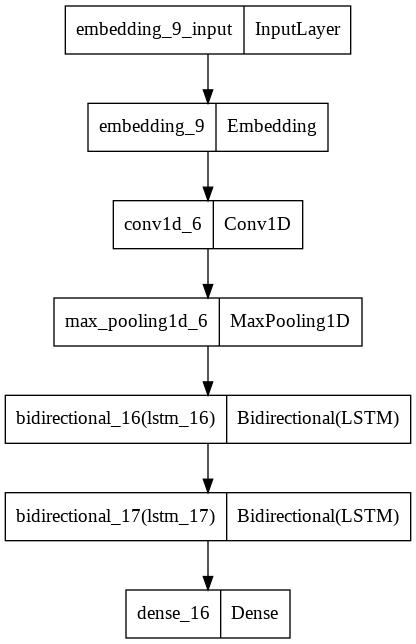

In [57]:
tf.keras.utils.plot_model(model, show_shapes=False)


In [58]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [59]:
%%time
num_epochs = 5
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

history = model.fit(
    x = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).prefetch(AUTO),
    validation_data=tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(AUTO),
    epochs=num_epochs,
    use_multiprocessing=True,
    workers=4
)


Epoch 1/5
1076/1076 [==============================] - 4136s 4s/step - loss: 0.3030 - accuracy: 0.8697 - val_loss: 0.2275 - val_accuracy: 0.9079
Epoch 2/5
1076/1076 [==============================] - 4046s 4s/step - loss: 0.1584 - accuracy: 0.9375 - val_loss: 0.2298 - val_accuracy: 0.9076
Epoch 3/5
1076/1076 [==============================] - 4034s 4s/step - loss: 0.0953 - accuracy: 0.9645 - val_loss: 0.2812 - val_accuracy: 0.9038
Epoch 4/5
1076/1076 [==============================] - 4103s 4s/step - loss: 0.0604 - accuracy: 0.9776 - val_loss: 0.3671 - val_accuracy: 0.8988
Epoch 5/5
1076/1076 [==============================] - 4143s 4s/step - loss: 0.0449 - accuracy: 0.9836 - val_loss: 0.3904 - val_accuracy: 0.9005
CPU times: user 9h 32min 37s, sys: 41min 57s, total: 10h 14min 34s
Wall time: 5h 42min 35s


Accuracy on training data is:- 98.35758209228516 %
Loss 4.4852957129478455
Accuracy on validation data is:- 90.04709124565125 %
Loss 39.03854191303253


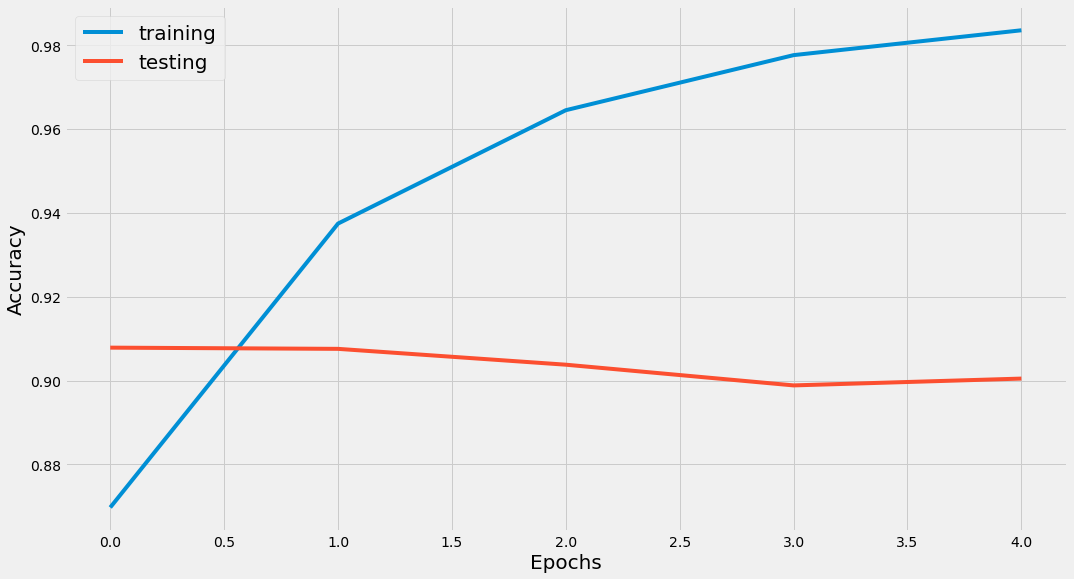

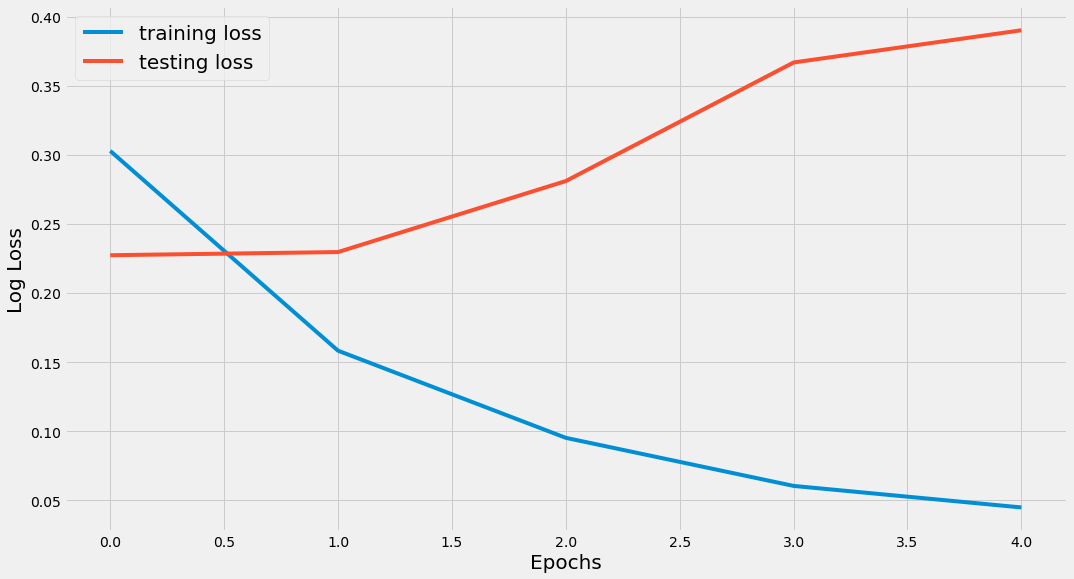

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

plt.plot(acc, label='training')
plt.plot(val_acc, label='testing')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(fontsize=20)
plt.show()

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='testing loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Log Loss', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [62]:
model.evaluate(x_train, y_train)
model.evaluate(x_test, y_test)

538/538 [==============================] - 401s 746ms/step - loss: 0.3904 - accuracy: 0.9005


[0.3903854787349701, 0.9004709124565125]

In [63]:
pred = model.predict(x_test)
pred_classes = np.argmax(pred, axis=1)

538/538 [==============================] - 398s 735ms/step


In [67]:
print(classification_report(y_test, pred_classes))

              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65      8212
         1.0       0.00      0.00      0.00      8989

    accuracy                           0.48     17201
   macro avg       0.24      0.50      0.32     17201
weighted avg       0.23      0.48      0.31     17201



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


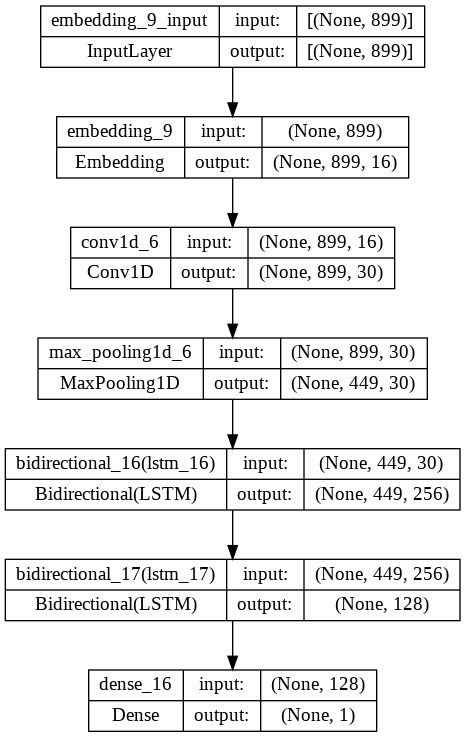

In [68]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [70]:
model.save("/content/model2")

In [71]:
del model

In [ ]:
#!mv saved_model '/content/backup'